# Reverse Ecology and Metatranscriptomics of Uncultivated Freshwater Actinobacteria

## Figure 2a/b: Completeness as a Function of Sample Size

### Overview
This figure will contain one or more plots showing how a tribe/clade's completeness varies as a function of the number of genomes sampled. The workflow contains the following steps:

For completeness:

1. Download reference genomes.
2. Extract concatenated marker gene sequences using [Phylosift](https://phylosift.wordpress.com/) or [CheckM](http://ecogenomics.github.io/CheckM/).
3. Assemble results into a matrix.
4. Compute min/max/mean for all clades and sample sizes.
5. Plot the results

### Step 1: Downloading Reference Genomes

The reference genomes used in this study are scattered throughout the web. __Later, I will write code to download the genomes to `data/refGenomes/fna`.__

### Step 2: Extract Marker Genes using Phylosift/CheckM

Phylosift was used to extract marker genes in a previous code cell, the analysis will not be repeated here. CheckM will be run using Actinobacterial-specific marker genes.

In [ ]:
%reset
# Import packages
import os
import subprocess

# Define folders
genomeDir = '../data/refGenomes/fna'
scratchDir = '../data/scratch'
checkMDir = scratchDir+'/checkm'

# Check that psInputDir exists: genomes for use with Phylosift will get
# transferred there
if not os.path.exists(checkMDir):
    os.makedirs(checkMDir)
    
# Run checkM
outFile = open(checkMDir+'/out.txt', 'w')
subprocess.call(['checkM', 'taxonomy_wf', 'phylum', 'Actinobacteria', genomeDir,
                 checkMDir], stdout=outFile)
outFile.close()

### Step 3: Aggregate Marker Gene Data

This chunk of code parses the output of Phylosift and CheckM. For each set of marker genes, the code generates a table in which rows are genomes, and columns indicate the presence/absence of a particular marker gene.

In [ ]:
%reset
# Import packages
import os
import pandas as pd
import re

# Define folders
genomeDir = '../data/refGenomes/fna'
scratchDir = '../data/scratch'
checkMDir = scratchDir+'/checkm'
resultsDir = '../figures'
samplingDir = resultsDir+'/fig2-sampling'
checkmGeneSet = checkMDir+'/Actinobacteria.ms'

# Check that samplingDir exists, as analyses will go there
if not os.path.exists(samplingDir):
    os.makedirs(samplingDir)

# Retrieve the list of genomes to process
genomeList = []
for item in os.listdir(genomeDir):
    if item.endswith('.fna'):
        genomeList.append(item)
        
genomeList = [genome.replace('.fna', '') for genome in genomeList]


### Phylosift

# Initialize an empty dataframe to store Phylosift Data
phylosiftDF = pd.DataFrame(columns=['MarkerGene'])

# Read in the markerSummary file as a dataframe and append to the previous        
for genome in genomeList:
    tempDF = pd.read_csv('PS_temp/'+genome+'.fna/alignDir/marker_summary.txt', names=['MarkerGene',genome], delimiter='\t')
    phylosiftDF = pd.merge(phylosiftDF, tempDF, how='outer', on='MarkerGene')

# Clean up the final data frame.
# Drop unwanted marker genes
phylosiftDF = phylosiftDF[phylosiftDF.MarkerGene.str.contains('DNGNGWU')]
# Replace all the NaN values with zeros
phylosiftDF.fillna(0, inplace=True)
# Index on 'Marker Gene'
phylosiftDF = phylosiftDF.set_index('MarkerGene')
phylosiftDF.index.name = None

# Write to file
pd.DataFrame.to_csv(phylosiftDF, samplingDir+'/phylosift.csv')


### CheckM

# Identify the marker genes used by CheckM
with open(checkmGeneSet) as inFile:
    statFile = inFile.readlines()
splitLine = statFile[1].split("\t")
markerGeneList = re.findall('PF\d+\.\d+', splitLine[5])
markerGeneList.extend(re.findall('TIGR\d+', splitLine[5]))

# Initialize an empty dataframe
checkmDF = pd.DataFrame(index=markerGeneList)
    
# Read in stat table
with open(checkMDir+'/storage/marker_gene_stats.tsv') as inFile:
    statFile = inFile.readlines()

# For each line of the array, split it along the '\t' character
for myLine in statFile:
    splitLine = myLine.split("\t")

# Add the first element of the array as a column to the dataframe
    checkmDF[splitLine[0]] = 0

# Regex to find all marker genes in the second line
    markerGeneList = re.findall('PF\d+\.\d+', splitLine[1])
    markerGeneList.extend(re.findall('TIGR\d+', splitLine[1]))

# For each element in the set, add a '1' at the appropriate location
    for markerGene in markerGeneList:
        checkmDF.loc[markerGene, splitLine[0]] = 1

# Replace all the NaN values with zeros
    checkmDF.fillna(0, inplace=True)

# Write to file
pd.DataFrame.to_csv(checkmDF, samplingDir+'/checkm.csv')

### Step 4: Compute Mean/Min/Max Completeness for each {Lineage/Clade/Tribe, Sample Size} Pairing

This section of code computes the data underlying the sampling completeness plots. For a given lineage, clade, or tribe, this chunk of code:

1. Identifies the number of genomes belonging to the group.
2. Computes all possible permutations of genomes for a given sample size.
3. For each permutation, computes the completeness.
4. Records the mean/min/max completeness for each sample.

In [ ]:
%reset
# Import packages
import random
import pandas as pd

# Define folders
externalDataDir = '../data/externalData'
taxonFile = externalDataDir+'/taxonomy.csv'
resultsDir = '../figures'
samplingDir = resultsDir+'/fig2-sampling'
phylosiftResults = samplingDir+'/phylosift.csv'
checkmResults = samplingDir+'/checkm.csv'

# Define parameters
sampleN = 1000

################################################################################

# Define a function to import taxonomy files
def importTaxonomy(taxonFile, level):

# Read in the taxonomic classification
    taxonClass = pd.DataFrame.from_csv(taxonFile, sep=',')
    taxonClass = taxonClass.dropna()
    
# Extract the unique tribes found in the dataset
    groupList = pd.unique(taxonClass[level].values)
    groupList.sort(axis=0)
    groupList = [ group for group in groupList if not group.startswith('Unknown') ]
    
# For each tribe, return the list of samples. Creates a dict and adds an entry
# for each tribe.
    groupSampleDict = {}

    for group in groupList:

# Identify the samples belonging to this tribe
        samples = taxonClass.loc[taxonClass[level] == group]
        samples = [sample for sample in samples.index]
        groupSampleDict[group] = samples
        
    return groupSampleDict

################################################################################

# Establish a dataframe giving the presence/absence of each marker gene in the genome
phylosiftRawDF = pd.read_csv(phylosiftResults, index_col=0, sep=',')
checkmRawDF = pd.read_csv(checkmResults, index_col=0, sep=',')

# Create dictionaries giving the samples which belong to each lineage/clade/tribe
lineageDict =  importTaxonomy(taxonFile, 'Lineage')
cladeDict =  importTaxonomy(taxonFile, 'Clade')
tribeDict =  importTaxonomy(taxonFile, 'Tribe')

# And a dict of these dicts to make looking easier
taxonDictList = [lineageDict, cladeDict, tribeDict]

for curDict in taxonDictList:
    print "Processing taxonomic level %d of %d" % (taxonDictList.index(curDict)+1, len(taxonDictList))  

    for group in curDict.keys():
        print "Processing group %d of %d" % (curDict.keys().index(group)+1, len(curDict.keys()))  
        
        # Create an empty dataframe to store the results, indexed by sample size
        checkmDF = pd.DataFrame(0.0, index=range(1,len(curDict[group])+1), 
                              columns=['Min', 'Mean', 'Max', 'St Dev'])
        
        phylosiftDF = pd.DataFrame(0.0, index=range(1,len(curDict[group])+1), 
                                columns=['Min', 'Mean', 'Max', 'St Dev'])
                
        # For each sample size (can use either dataframe, indices are the same)
        for sampleSize in checkmDF.index:

            print "Processing sample size %d of %d" % (sampleSize, len(checkmDF.index))  
        
            # Create a list of all 100 random samples, and a dataframe to store the completeness
            sampleList = [tuple([random.choice(curDict[group]) for _ in range(sampleSize)]) for _ in range(sampleN)]

            # It is possible to have identical samples, so we can't index on
            # the sample. Instead, index on sample number
            sampleDF = pd.DataFrame(0.0, index=range(len(sampleList)), 
                                    columns=['Phylosift', 'CheckM'])
            
            sampleIndex = 0
            for sample in sampleList:
                # Create temporary dataframes containing only the appropriate columns
                phylosiftTempDF = phylosiftRawDF[list(sample)]
                checkmTempDF = checkmRawDF[list(sample)]

                # Estimate the percent completeness. First, merge the columns, 
                # counting the number of marker genes across the genomes.
                mergePhylosiftTempDF = phylosiftTempDF.sum(axis=1)
                mergeCheckmTempDF = checkmTempDF.sum(axis=1)
                
                # Then, count the number of non-zero occurences and normalize by
                # the total number of marker genes
                phylosiftEst = sum(mergePhylosiftTempDF !=0) / float(len(mergePhylosiftTempDF))
                checkmEst = sum(mergeCheckmTempDF !=0) / float(len(mergeCheckmTempDF))
                
                # And place the result in the sampleDF for the appropriate sample
                sampleDF.loc[sampleIndex, 'Phylosift'] = phylosiftEst
                sampleDF.loc[sampleIndex, 'CheckM'] = checkmEst
                sampleIndex = sampleIndex + 1
            
            # Compute the min, max, and mean estimated completeness
            # Store under the appropriate sample size            
            phylosiftDF.loc[sampleSize, 'Min'] = sampleDF['Phylosift'].min()
            phylosiftDF.loc[sampleSize, 'Mean'] = sampleDF['Phylosift'].mean()
            phylosiftDF.loc[sampleSize, 'Max'] = sampleDF['Phylosift'].max()
            phylosiftDF.loc[sampleSize, 'St Dev'] = sampleDF['Phylosift'].std()
            
            checkmDF.loc[sampleSize, 'Min'] = sampleDF['CheckM'].min()
            checkmDF.loc[sampleSize, 'Mean'] = sampleDF['CheckM'].mean()
            checkmDF.loc[sampleSize, 'Max'] = sampleDF['CheckM'].max()
            checkmDF.loc[sampleSize, 'St Dev'] = sampleDF['CheckM'].std()
            
        # Write the results to file
        pd.DataFrame.to_csv(phylosiftDF, samplingDir+'/'+group+'-phylosift.csv')
        pd.DataFrame.to_csv(checkmDF, samplingDir+'/'+group+'-checkm.csv')

### Step 5: Plot Mean Completeness for Tribe/Clade as a Function of Sample Size

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Processing taxonomic level 1 of 3
Processing group 1 of 1
Processing taxonomic level 2 of 3
Processing group 1 of 3
Processing group 2 of 3
Processing group 3 of 3
Processing taxonomic level 3 of 3
Processing group 1 of 7
Processing group 2 of 7
Processing group 3 of 7
Processing group 4 of 7
Processing group 5 of 7
Processing group 6 of 7
Processing group 7 of 7


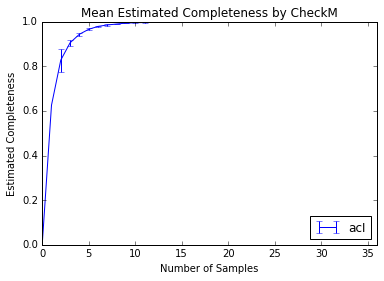

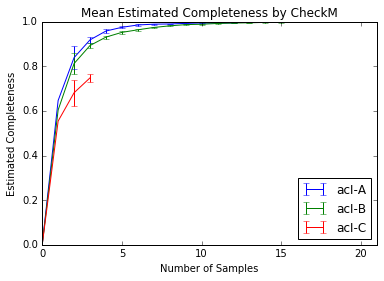

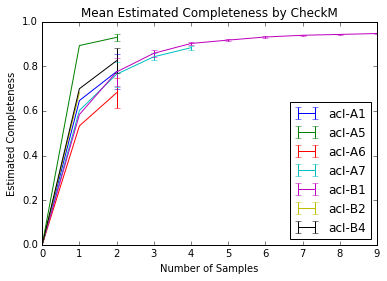

In [11]:
%reset
# Import packages
import inspect
import math
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
%matplotlib inline

# Define folders
externalDataDir = '../data/externalData'
taxonFile = externalDataDir+'/taxonomy.csv'
resultsDir = '../figures'
samplingDir = resultsDir+'/fig2-sampling'

# Define parameters
confidence = 0.95
sampleN = 1000

################################################################################

# Define a function to import taxonomy files
def importTaxonomy(taxonFile, level):

# Read in the taxonomic classification
    taxonClass = pd.DataFrame.from_csv(taxonFile, sep=',')
    taxonClass = taxonClass.dropna()
    
# Extract the unique tribes found in the dataset
    groupList = pd.unique(taxonClass[level].values)
    groupList.sort(axis=0)
    groupList = [ group for group in groupList if not group.startswith('Unknown') ]
    
# For each tribe, return the list of samples. Creates a dict and adds an entry
# for each tribe.
    groupSampleDict = {}

    for group in groupList:

# Identify the samples belonging to this tribe
        samples = taxonClass.loc[taxonClass[level] == group]
        samples = [sample for sample in samples.index]
        groupSampleDict[group] = samples
        
    return groupSampleDict

################################################################################

# Create dictionaries giving the samples which belong to each lineage/clade/tribe
lineageDict =  importTaxonomy(taxonFile, 'Lineage')
cladeDict =  importTaxonomy(taxonFile, 'Clade')
tribeDict =  importTaxonomy(taxonFile, 'Tribe')

# And a dict of these dicts to make looking easier
taxonDictList = [lineageDict, cladeDict, tribeDict]

for curDict in taxonDictList:
    print "Processing taxonomic level %d of %d" % (taxonDictList.index(curDict)+1, len(taxonDictList))  

    # Find the max sample size, to use for DF indexing
    sampleLenList = []
    for group in curDict.keys():
        sampleLenList.append(len(curDict[group]))

    # Create an empty dataframe to store the results, indexed by sample size
    checkmDF = pd.DataFrame(index=range(1,max(sampleLenList)+1), columns=curDict.keys())
    checkmCIDF = pd.DataFrame(index=range(1,max(sampleLenList)+1), columns=curDict.keys())
    
    phylosiftDF = pd.DataFrame(index=range(1,max(sampleLenList)+1), columns=curDict.keys())    
    phylosiftCIDF = pd.DataFrame(index=range(1,max(sampleLenList)+1), columns=curDict.keys())
        
    for group in curDict.keys():
        print "Processing group %d of %d" % (curDict.keys().index(group)+1, len(curDict.keys()))
        
        # Read in the dataframe of estimated completeness and add 'Mean' to the
        # results dataframe
        checkmGroupDF = pd.read_csv(samplingDir+'/'+group+'-checkm.csv', index_col=0, sep=',')
        checkmDF[group] = checkmGroupDF['Mean']

        phylosiftGroupDF = pd.read_csv(samplingDir+'/'+group+'-phylosift.csv', index_col=0, sep=',')
        phylosiftDF[group] = phylosiftGroupDF['Mean']

        # Compute student's t-scores to use with calculation of confidence interval.
        # Shorten to the approptiate length: only retain t-scores for sample sizes
        # in the group
        studentT = scipy.stats.t.ppf((1+confidence) / 2, checkmDF.index-1)
        studentT = studentT[0:len(curDict[group])]

        # Compute the confidence interval
        checkmCIDF[group] = studentT* checkmGroupDF['St Dev'] / math.sqrt(sampleN)
        phylosiftCIDF[group] = studentT* phylosiftGroupDF['St Dev'] / math.sqrt(sampleN)
        
    # Sort dataframe columns alphabetically
    checkmDF = checkmDF.sort_index(axis=1)
    phylosiftDF = phylosiftDF.sort_index(axis=1)
        
    # Add zero-row and resort on the index
    appendDF = pd.DataFrame(0, index = [0], columns=curDict.keys())

    checkmDF = checkmDF.append(appendDF)
    checkmDF = checkmDF.sort_index(axis=0)
    
    phylosiftDF = phylosiftDF.append(appendDF)
    phylosiftDF = phylosiftDF.sort_index(axis=0)
    
    checkmCIDF = checkmCIDF.append(appendDF)
    checkmCIDF = checkmCIDF.sort_index(axis=0)
    
    phylosiftCIDF = phylosiftCIDF.append(appendDF)
    phylosiftCIDF = phylosiftCIDF.sort_index(axis=0)
    
    # Plot the results
    plt.figure()
    plt.title('Mean Estimated Completeness by CheckM')
    for column in checkmDF.columns:
        plt.errorbar(checkmDF.index, checkmDF[column], yerr=checkmCIDF[column],linewidth=1)
    plt.xlim(0, max(checkmDF.index))
    plt.ylim(0, 1)
    plt.xlabel('Number of Samples')
    plt.ylabel('Estimated Completeness')
    plt.legend(checkmDF.columns, loc='lower right')
    plt.savefig(samplingDir+'/'+'completeness-'+str(taxonDictList.index(curDict)+1)+'.png')

## Figure 2c: Core- and Pan-Genome as a Function of Sample Size

### Overview
This figure will contain one or more plots showing how a tribe/clade's core- and pan-genome varies as a function of the number of genomes sampled. The workflow contains the following steps:

For completeness:

1. Download reference genomes.
2. Compute actinoCOGs using OrthoMCL.
3. Compute min/max/mean for all clades and sample sizes.
4. Plot the results.

### Step 1: Downloading Reference Genomes

The reference genomes used in this study are scattered throughout the web. __Later, I will write code to download the genomes to `data/refGenomes/fna`.__

### Step 2: Compute actinoCOGs

The code and scripts to perform this step are currently in my OrthoMCL Github repo.  __I will incorporate this code into this notebook at a later date.__ I have stored the output of OrthoMCL in `data/orthoMCL`.

### Step 3: Compute min/max/mean for all clades and sample sizes.

In [ ]:
%reset
# Import packages
import pandas as pd
import random
import sys

# Define folders
dataDir = '../data'
externalDataDir = dataDir+'/externalData'
taxonFile = externalDataDir+'/taxonomy.csv'
orthomclDir = dataDir+'/orthoMCL'
resultsDir = '../figures'
samplingDir = resultsDir+'/fig2-sampling'

# Define parameters
sampleN = 1000

################################################################################

# Define a function to import taxonomy files
def importTaxonomy(taxonFile, level):

# Read in the taxonomic classification
    taxonClass = pd.DataFrame.from_csv(taxonFile, sep=',')
    taxonClass = taxonClass.dropna()
    
# Extract the unique tribes found in the dataset
    groupList = pd.unique(taxonClass[level].values)
    groupList.sort(axis=0)
    groupList = [ group for group in groupList if not group.startswith('Unknown') ]
    
# For each tribe, return the list of samples. Creates a dict and adds an entry
# for each tribe.
    groupSampleDict = {}

    for group in groupList:

# Identify the samples belonging to this tribe
        samples = taxonClass.loc[taxonClass[level] == group]
        samples = [sample for sample in samples.index]
        groupSampleDict[group] = samples
        
    return groupSampleDict

################################################################################

# Establish a dataframe giving the presence/absence of each marker gene in the genome
cogRawDF = pd.read_csv(orthomclDir+'/cogTable.csv', index_col=0, sep=',')
cogRawDF = cogRawDF.replace(to_replace='.+', value=1, regex=True)
cogRawDF = cogRawDF.fillna(0)

# Create dictionaries giving the samples which belong to each lineage/clade/tribe
lineageDict =  importTaxonomy(taxonFile, 'Lineage')
cladeDict =  importTaxonomy(taxonFile, 'Clade')
tribeDict =  importTaxonomy(taxonFile, 'Tribe')

# And a dict of these dicts to make looking easier
taxonDictList = [lineageDict, cladeDict, tribeDict]

for curDict in taxonDictList:
    print "Processing taxonomic level %d of %d" % (taxonDictList.index(curDict)+1, len(taxonDictList))  

    for group in curDict.keys():
        print "Processing group %d of %d" % (curDict.keys().index(group)+1, len(curDict.keys()))  
        
        # Create an empty dataframe to store the results, indexed by sample size
        coregenomeDF = pd.DataFrame(0.0, index=range(1,len(curDict[group])+1), 
                              columns=['Min', 'Mean', 'Max', 'St Dev'])
        
        pangenomeDF = pd.DataFrame(0.0, index=range(1,len(curDict[group])+1), 
                              columns=['Min', 'Mean', 'Max', 'St Dev'])
        
        accgenomeDF = pd.DataFrame(0.0, index=range(1,len(curDict[group])+1), 
                              columns=['Min', 'Mean', 'Max', 'St Dev'])
                
        # For each sample size (can use either dataframe, indices are the same)
        for sampleSize in pangenomeDF.index:

            print "Processing sample size %d of %d" % (sampleSize, len(pangenomeDF.index))  
        
            # Create a list of all 100 random samples, and a dataframe to store the completeness
            sampleList = [tuple([random.choice(curDict[group]) for _ in range(sampleSize)]) for _ in range(sampleN)]

            # It is possible to have identical samples, so we can't index on
            # the sample. Instead, index on sample number
            sampleDF = pd.DataFrame(0.0, index=range(len(sampleList)), 
                                    columns=['Core', 'Pan', 'Accessory'])

            sampleIndex = 0
            for sample in sampleList:

                sys.stdout.write("\rLevel 4: Processing sample %d of %d" % (sampleIndex+1, len(sampleList)))
                sys.stdout.flush()
        
                # Create temporary dataframes containing only the appropriate columns
                cogTempDF = cogRawDF[list(sample)]

                # Estimate the percent completeness. First, merge the columns, 
                # counting the number of marker genes across the genomes.
                mergeCogTempDF = cogTempDF.sum(axis=1)
                
                # Then, count the number of COGs present in all (core) or any
                # (pan). Compute size of accessory genome. Store all results.
                sampleDF.loc[sampleIndex, 'Core'] = sum(mergeCogTempDF == sampleSize)
                sampleDF.loc[sampleIndex, 'Pan'] = sum(mergeCogTempDF != 0)
                sampleDF.loc[sampleIndex, 'Accessory'] = sum(mergeCogTempDF != 0) - sum(mergeCogTempDF == sampleSize)
                sampleIndex = sampleIndex+1
            
            # Compute the min, max, and mean estimated completeness
            # Store under the appropriate sample size            
            coregenomeDF.loc[sampleSize, 'Min'] = sampleDF['Core'].min()
            coregenomeDF.loc[sampleSize, 'Mean'] = sampleDF['Core'].mean()
            coregenomeDF.loc[sampleSize, 'Max'] = sampleDF['Core'].max()
            coregenomeDF.loc[sampleSize, 'St Dev'] = sampleDF['Core'].std()

            pangenomeDF.loc[sampleSize, 'Min'] = sampleDF['Pan'].min()
            pangenomeDF.loc[sampleSize, 'Mean'] = sampleDF['Pan'].mean()
            pangenomeDF.loc[sampleSize, 'Max'] = sampleDF['Pan'].max()
            pangenomeDF.loc[sampleSize, 'St Dev'] = sampleDF['Pan'].std()
            
            accgenomeDF.loc[sampleSize, 'Min'] = sampleDF['Accessory'].min()
            accgenomeDF.loc[sampleSize, 'Mean'] = sampleDF['Accessory'].mean()
            accgenomeDF.loc[sampleSize, 'Max'] = sampleDF['Accessory'].max()
            accgenomeDF.loc[sampleSize, 'St Dev'] = sampleDF['Accessory'].std()
            
        # Write the results to file
        pd.DataFrame.to_csv(coregenomeDF, samplingDir+'/'+group+'-core.csv')
        pd.DataFrame.to_csv(pangenomeDF, samplingDir+'/'+group+'-pan.csv')
        pd.DataFrame.to_csv(accgenomeDF, samplingDir+'/'+group+'-accessory.csv')


### Step 4: Plot Pan/Core/Accessory-Genome Size for Tribe/Clade as a Function of Sample Size

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Processing taxonomic level 1 of 3
Processing taxonomic level 2 of 3
Processing taxonomic level 3 of 3


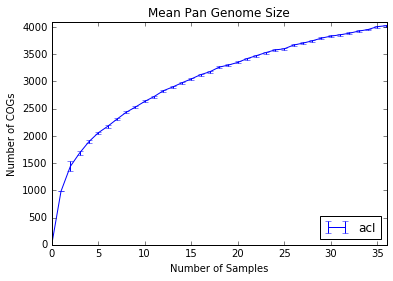

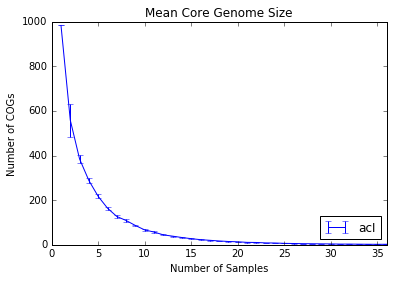

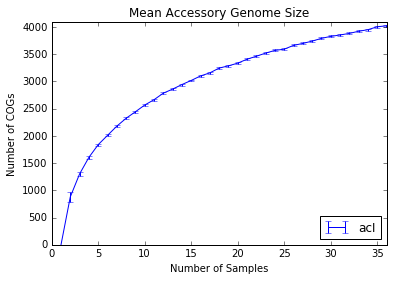

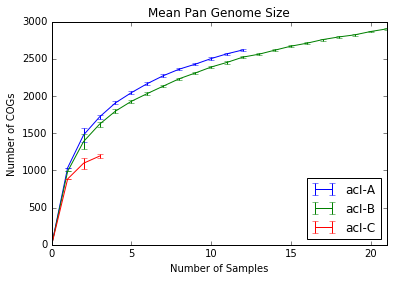

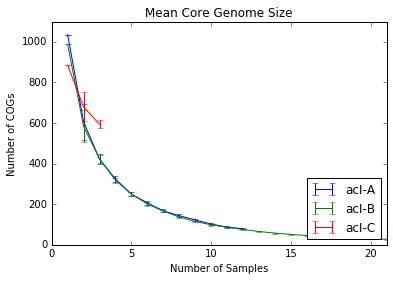

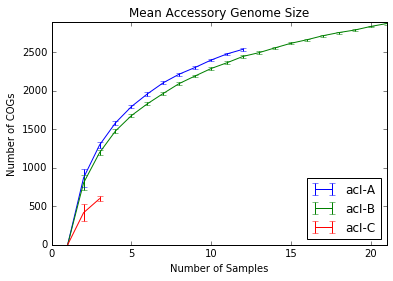

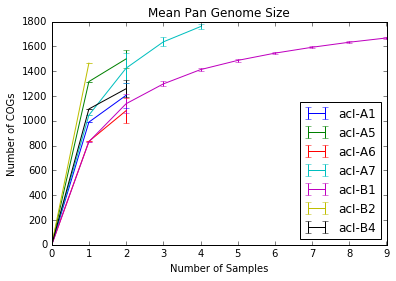

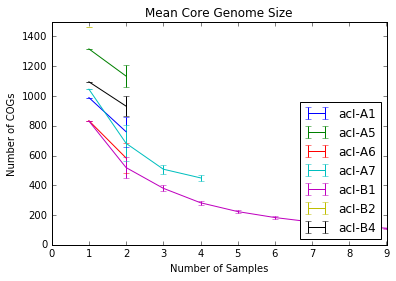

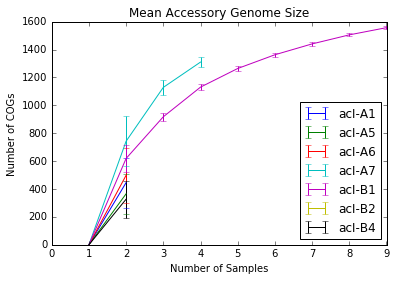

In [20]:
%reset
# Import packages
import math
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
%matplotlob inline

# Define folders
externalDataDir = '../data/externalData'
taxonFile = externalDataDir+'/taxonomy.csv'
resultsDir = '../figures'
samplingDir = resultsDir+'/fig2-sampling'

# Define parameters
confidence = 0.95
sampleN = 1000

################################################################################

# Define a function to import taxonomy files
def importTaxonomy(taxonFile, level):

# Read in the taxonomic classification
    taxonClass = pd.DataFrame.from_csv(taxonFile, sep=',')
    taxonClass = taxonClass.dropna()
    
# Extract the unique tribes found in the dataset
    groupList = pd.unique(taxonClass[level].values)
    groupList.sort(axis=0)
    groupList = [ group for group in groupList if not group.startswith('Unknown') ]
    
# For each tribe, return the list of samples. Creates a dict and adds an entry
# for each tribe.
    groupSampleDict = {}

    for group in groupList:

# Identify the samples belonging to this tribe
        samples = taxonClass.loc[taxonClass[level] == group]
        samples = [sample for sample in samples.index]
        groupSampleDict[group] = samples
        
    return groupSampleDict

# Define a rounding function to round to the nearest hundred
def roundup100(x):
    return int(math.ceil(x / 100.0)) * 100

################################################################################

# Create dictionaries giving the samples which belong to each lineage/clade/tribe
lineageDict =  importTaxonomy(taxonFile, 'Lineage')
cladeDict =  importTaxonomy(taxonFile, 'Clade')
tribeDict =  importTaxonomy(taxonFile, 'Tribe')

# And a dict of these dicts to make looking easier
taxonDictList = [lineageDict, cladeDict, tribeDict]

for curDict in taxonDictList:
    print "Processing taxonomic level %d of %d" % (taxonDictList.index(curDict)+1, len(taxonDictList))  

    # Find the max sample size, to use for DF indexing
    sampleLenList = []
    for group in curDict.keys():
        sampleLenList.append(len(curDict[group]))

    # Create an empty dataframe to store the results, indexed by sample size
    panDF = pd.DataFrame(index=range(1,max(sampleLenList)+1), columns=curDict.keys())
    coreDF = pd.DataFrame(index=range(1,max(sampleLenList)+1), columns=curDict.keys())
    accessoryDF = pd.DataFrame(index=range(1,max(sampleLenList)+1), columns=curDict.keys())
        
    panCIDF = pd.DataFrame(index=range(1,max(sampleLenList)+1), columns=curDict.keys())
    coreCIDF = pd.DataFrame(index=range(1,max(sampleLenList)+1), columns=curDict.keys())
    accessoryCIDF = pd.DataFrame(index=range(1,max(sampleLenList)+1), columns=curDict.keys())
    
    for group in curDict.keys():
        
        # Read in the dataframe of estimated completeness and add 'Mean' to the
        # results dataframe
        panGroupDF = pd.read_csv(samplingDir+'/'+group+'-pan.csv', index_col=0, sep=',')
        panDF[group] = panGroupDF['Mean']
        
        coreGroupDF = pd.read_csv(samplingDir+'/'+group+'-core.csv', index_col=0, sep=',')
        coreDF[group] = coreGroupDF['Mean']
        
        accessoryGroupDF = pd.read_csv(samplingDir+'/'+group+'-accessory.csv', index_col=0, sep=',')
        accessoryDF[group] = accessoryGroupDF['Mean']
        
        # Compute student's t-scores to use with calculation of confidence interval.
        # Shorten to the approptiate length: only retain t-scores for sample sizes
        # in the group
        studentT = scipy.stats.t.ppf((1+confidence) / 2, panDF.index-1)
        studentT = studentT[0:len(curDict[group])]

        # Compute the confidence interval and set the rest to zeros
        panCIDF[group] = studentT* panGroupDF['St Dev'] / math.sqrt(sampleN)
        coreCIDF[group] = studentT* coreGroupDF['St Dev'] / math.sqrt(sampleN)
        accessoryCIDF[group] = studentT* accessoryGroupDF['St Dev'] / math.sqrt(sampleN)
        
        panCIDF[group] =  panCIDF[group].fillna(0)
        coreCIDF[group] =  coreCIDF[group].fillna(0)
        accessoryCIDF[group] =  accessoryCIDF[group].fillna(0)
        
    # Sort dataframe columns alphabetically
    panDF = panDF.sort_index(axis=1)
    panCIDF = panCIDF.sort_index(axis=1)
    coreDF = coreDF.sort_index(axis=1)
    coreCIDF = coreCIDF.sort_index(axis=1)
    accessoryDF = accessoryDF.sort_index(axis=1)    
    accessoryCIDF = accessoryCIDF.sort_index(axis=1)

    # Add leading 0s to pangenome
    appendDF = pd.DataFrame(0, index = [0], columns=curDict.keys())
    panDF = panDF.append(appendDF)
    panDF = panDF.sort_index(axis=0)
    panCIDF = panCIDF.append(appendDF)
    panCIDF = panCIDF.sort_index(axis=0)
        
    # Plot the results
    plt.figure()
    plt.title('Mean Pan Genome Size')
    for column in panDF.columns:
        plt.errorbar(panDF.index, panDF[column].tolist(), yerr=panCIDF[column].tolist())
    plt.xlim(0, max(panDF.index))
    plt.ylim(0, roundup100(panDF.max().max()))
    plt.xlabel('Number of Samples')
    plt.ylabel('Number of COGs')
    plt.legend(panDF.columns, loc='lower right')
    plt.savefig(samplingDir+'/'+'panGenome-'+str(taxonDictList.index(curDict)+1)+'.png')
    
    # Plot the results
    plt.figure()
    plt.title('Mean Core Genome Size')
    for column in coreDF.columns:
        plt.errorbar(coreDF.index, coreDF[column].tolist(), yerr=coreCIDF[column].tolist())
    plt.xlim(0, max(coreDF.index))
    plt.ylim(0, roundup100(coreDF.max().max()))
    plt.xlabel('Number of Samples')
    plt.ylabel('Number of COGs')
    plt.legend(coreDF.columns, loc='lower right')
    plt.savefig(samplingDir+'/'+'coreGenome-'+str(taxonDictList.index(curDict)+1)+'.png')
    
    # Plot the results
    plt.figure()
    plt.title('Mean Accessory Genome Size')
    for column in accessoryDF.columns:
        plt.errorbar(accessoryDF.index, accessoryDF[column].tolist(), yerr=accessoryCIDF[column].tolist())
    plt.xlim(0, max(accessoryDF.index))
    plt.ylim(0, roundup100(accessoryDF.max().max()))
    plt.xlabel('Number of Samples')
    plt.ylabel('Number of COGs')
    plt.legend(accessoryDF.columns, loc='lower right')
    plt.savefig(samplingDir+'/'+'accessoryGenome-'+str(taxonDictList.index(curDict)+1)+'.png')

## Simplify Completeness Estimate for Manuscript

This section makes two plots of completeness, one for clade and one for tribe.

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Processing taxonomic level 1 of 2
Processing group 1 of 3
Processing group 2 of 3
Processing group 3 of 3
Processing taxonomic level 2 of 2
Processing group 1 of 7
Processing group 2 of 7
Processing group 3 of 7
Processing group 4 of 7
Processing group 5 of 7
Processing group 6 of 7
Processing group 7 of 7


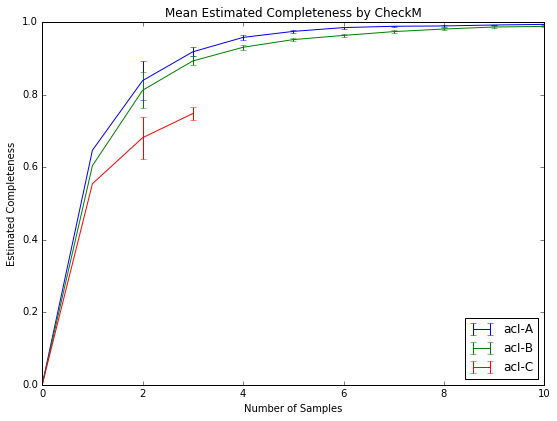

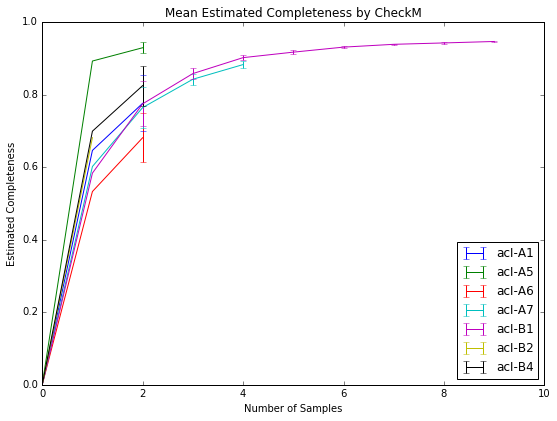

In [15]:
%reset
# Import packages
import inspect
import math
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
%matplotlib inline

# Define folders
externalDataDir = '../data/externalData'
taxonFile = externalDataDir+'/taxonomy.csv'
resultsDir = '../figures'
samplingDir = resultsDir+'/fig2-sampling'

# Define parameters
confidence = 0.95
sampleN = 1000

################################################################################

# Define a function to import taxonomy files
def importTaxonomy(taxonFile, level):

# Read in the taxonomic classification
    taxonClass = pd.DataFrame.from_csv(taxonFile, sep=',')
    taxonClass = taxonClass.dropna()
    
# Extract the unique tribes found in the dataset
    groupList = pd.unique(taxonClass[level].values)
    groupList.sort(axis=0)
    groupList = [ group for group in groupList if not group.startswith('Unknown') ]
    
# For each tribe, return the list of samples. Creates a dict and adds an entry
# for each tribe.
    groupSampleDict = {}

    for group in groupList:

# Identify the samples belonging to this tribe
        samples = taxonClass.loc[taxonClass[level] == group]
        samples = [sample for sample in samples.index]
        groupSampleDict[group] = samples
        
    return groupSampleDict

################################################################################

# Create dictionaries giving the samples which belong to each lineage/clade/tribe
#lineageDict =  importTaxonomy(taxonFile, 'Lineage')
cladeDict =  importTaxonomy(taxonFile, 'Clade')
tribeDict =  importTaxonomy(taxonFile, 'Tribe')

# And a dict of these dicts to make looking easier
taxonDictList = [cladeDict, tribeDict]

for curDict in taxonDictList:
    print "Processing taxonomic level %d of %d" % (taxonDictList.index(curDict)+1, len(taxonDictList))  

    # Find the max sample size, to use for DF indexing
    sampleLenList = []
    for group in curDict.keys():
        sampleLenList.append(len(curDict[group]))

    # Create an empty dataframe to store the results, indexed by sample size
    checkmDF = pd.DataFrame(index=range(1,max(sampleLenList)+1), columns=curDict.keys())
    checkmCIDF = pd.DataFrame(index=range(1,max(sampleLenList)+1), columns=curDict.keys())
        
    for group in curDict.keys():
        print "Processing group %d of %d" % (curDict.keys().index(group)+1, len(curDict.keys()))
        
        # Read in the dataframe of estimated completeness and add 'Mean' to the
        # results dataframe
        checkmGroupDF = pd.read_csv(samplingDir+'/'+group+'-checkm.csv', index_col=0, sep=',')
        checkmDF[group] = checkmGroupDF['Mean']

        # Compute student's t-scores to use with calculation of confidence interval.
        # Shorten to the approptiate length: only retain t-scores for sample sizes
        # in the group
        studentT = scipy.stats.t.ppf((1+confidence) / 2, checkmDF.index-1)
        studentT = studentT[0:len(curDict[group])]

        # Compute the confidence interval
        checkmCIDF[group] = studentT* checkmGroupDF['St Dev'] / math.sqrt(sampleN)
        
    # Sort dataframe columns alphabetically
    checkmDF = checkmDF.sort_index(axis=1)
        
    # Add zero-row and resort on the index
    appendDF = pd.DataFrame(0, index = [0], columns=curDict.keys())

    checkmDF = checkmDF.append(appendDF)
    checkmDF = checkmDF.sort_index(axis=0)
  
    checkmCIDF = checkmCIDF.append(appendDF)
    checkmCIDF = checkmCIDF.sort_index(axis=0)
    
    # Plot the results
    plt.figure(figsize=(9, 6.5))
    plt.title('Mean Estimated Completeness by CheckM')
    for column in checkmDF.columns:
        plt.errorbar(checkmDF.index, checkmDF[column], yerr=checkmCIDF[column],linewidth=1)
    plt.xlim(0, 10)
    plt.ylim(0, 1)
    plt.xlabel('Number of Samples')
    plt.ylabel('Estimated Completeness')
    plt.legend(checkmDF.columns, loc='lower right')
    plt.savefig(samplingDir+'/'+'completeness-'+str(taxonDictList.index(curDict)+1)+'.svg')